In [ ]:
To Be Done

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

# Risk Management and Capital Allocation

Fund managers, endowment managers, and professional delegated money managers in general very rarely can allocate capital freely

It is frequently the case that the ultimate investors impose on them a variety of restriction in the investment opportunity set.

- Restrictions on the sectors they invest
- Restrictions on the whether they can go short
- Restrictions on the use of explicit leverage
- Restrict on the use of derivative and embedded leverage

These type of restrictions are simple in the sense that they simply limit the set of instruments you are considering. 

They are static in nature.

Another set of constraints imposes time-varying restrictions on what the manager can do

- Risk limits: given a model for risk, it specifies that the portfolio must have variance lower than a certain limit
- Tracking error constraints: given a benchmark, this imposes limits on the portfolio residual risk--the volatility of the portfolio abnormal return relative to the benchmark


What makes implementation of these limits challenging is that risk is highly time-varying.

We start discussing a very standard approach to measure risk

## Measuring Time-varying risk


The variance of a portfolio is

$$Var_t(X_tR^e_{t+1})$$

where 
- $X_t$ is your portfolio weights in date t for investment in date t+1,
- $R_{t+1}$ is the vector of asset excess returns during the holding period, i.e. from date $t$ to date $t+1$.
- $Var_t() denotes the variance of this random variable given all we know in date $t$


### Time-varying risk in a single asset (or trading strategy)

There are two main approaches we can take

- Realized Variance

- Garch approach










### The Realized variance approach


Say you have daily data on the returns of an asset $R_{t}$. The realized variance is defined as:

$$RV_{t} = \sum_{i=1}^{N} R_{t-i}^{2}$$

 where $N$ is the number of days in the past you want to consider. 

The idea is that the realized variance is The higher the realized variance, the more the returns fluctuate.

Note here that we ignore the expected return of the asset, which at such high frequencies is assumed to be zero.

Armed with this estimate we can then run a forecasting regression:

- Can use lags

- Can use option based measures of volatility, which also encode future information about what market participants think about future risk

In [2]:
# lets strat by importing daily data on the market
import pandas_datareader.data as web

# Define the start and end dates
end_date = '2024-01-01'
start_date = '1926-01-01'

# Define the ticker symbol for the market factor
ticker = 'F-F_Research_Data_Factors_daily'

# Fetch the data from Ken French website
data = web.DataReader(ticker, 'famafrench', start_date, end_date)

# Extract the market factor data
market_factor = data[0]['Mkt-RF']


Below I compute the variance across days in a given month, so I obtain a daily variance measure ( recall that the variance takes the mean of the square residuals)

<AxesSubplot:xlabel='Date'>

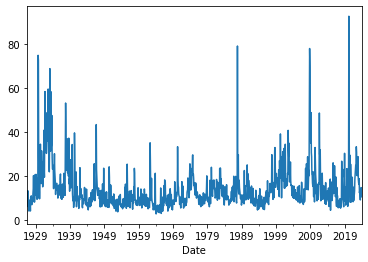

In [3]:

market_RV = market_factor.resample('M').var()
((market_RV*252)**0.5).plot()

below I will just sum the square returns, so I obtain a monthly variance measure

<AxesSubplot:xlabel='Date'>

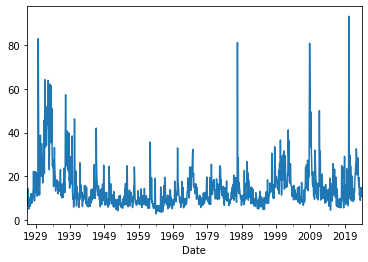

In [4]:
# or alternatively, ignoring the mean
market_RV = market_factor.resample('M').agg(lambda x: (np.sum(x**2)))
((market_RV*12)**0.5).plot()

LEts do some forecasting.

Basic model

$$RV_{t+1}=a+bRV_t+\epsilon_{t+1}$$

In [5]:
import statsmodels.api as sm

# Create lagged variable
market_RV=pd.DataFrame(market_RV)
market_RV.columns=['RV']
market_RV['RVl1']= market_RV.RV.shift()

# Remove missing values
market_RV = market_RV.dropna()


# Add constant term
X = sm.add_constant(market_RV.RVl1)

# Fit the regression model
model = sm.OLS(market_RV.RV, X)
results1 = model.fit()

# Print the regression results
print(results1.summary())


                            OLS Regression Results                            
Dep. Variable:                     RV   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     510.5
Date:                Wed, 01 May 2024   Prob (F-statistic):           4.68e-94
Time:                        18:22:59   Log-Likelihood:                -6073.7
No. Observations:                1169   AIC:                         1.215e+04
Df Residuals:                    1167   BIC:                         1.216e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.5001      1.423      8.079      0.0

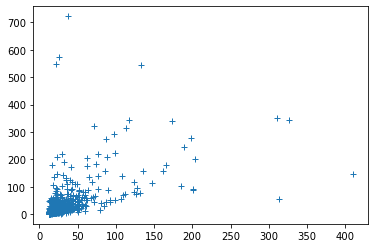

In [6]:
plt.plot(results1.fittedvalues,market_RV.RV, '+')

What if I do in Standard Deviation? Does it work better?

Bu what do I care about?

How would you do it?

Does additional lags help?

In [6]:

market_RV['RVl2']= market_RV.RV.shift(2)
market_RV['RVl3']= market_RV.RV.shift(3)
# Remove missing values
market_RV = market_RV.dropna()


# Add constant term
X = sm.add_constant(market_RV.loc[:,'RVl1':'RVl3'])

# Fit the regression model
model = sm.OLS(market_RV.RV, X)
results2 = model.fit()

# Print the regression results
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:                     RV   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     183.8
Date:                Wed, 01 May 2024   Prob (F-statistic):           1.53e-97
Time:                        18:23:15   Log-Likelihood:                -6044.6
No. Observations:                1166   AIC:                         1.210e+04
Df Residuals:                    1162   BIC:                         1.212e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.1214      1.481      6.158      0.0

What if it really matters the very recent past?

Lets look at also last five days of the month

<AxesSubplot:xlabel='Date'>

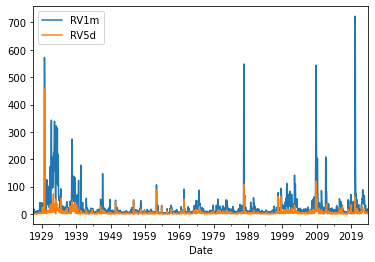

In [14]:
market_RV = market_factor.resample('M').agg({'RV1m': lambda x: (np.sum(x**2)), 'RV5d': lambda x: (np.sum(x.iloc[-5:,]**2))})


market_RV.plot()

In [15]:

market_RV['RV1ml1']= market_RV.RV1m.shift()
market_RV['RV5dl1']= market_RV.RV5d.shift()
# Remove missing values
market_RV = market_RV.dropna()


# Add constant term
X = sm.add_constant(market_RV[['RV1ml1','RV5dl1']])

# Fit the regression model
model = sm.OLS(market_RV.RV1m, X)
results3 = model.fit()

# Print the regression results
print(results3.summary())


                            OLS Regression Results                            
Dep. Variable:                   RV1m   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     272.3
Date:                Wed, 01 May 2024   Prob (F-statistic):           8.98e-98
Time:                        18:26:09   Log-Likelihood:                -6061.7
No. Observations:                1169   AIC:                         1.213e+04
Df Residuals:                    1166   BIC:                         1.214e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.3676      1.410      8.063      0.0

What about forward looking information from option markets?

We can use a measure of implied volatility--say the VIX


In [10]:
import pandas_datareader.data as web

# Define the start and end dates
start_date = '1990-01-01'
end_date = '2024-01-01'

# Define the ticker symbol for the VIX
ticker = 'VIXCLS'

# Fetch the data from FRED
vix_data = web.DataReader(ticker, 'fred', start_date, end_date)
vix_data.columns=['VIX']
vix_data['VIXl1']=vix_data.VIX.shift()
# Print the VIX data
print(vix_data)


              VIX  VIXl1
DATE                    
1990-01-02  17.24    NaN
1990-01-03  18.19  17.24
1990-01-04  19.22  18.19
1990-01-05  20.11  19.22
1990-01-08  20.26  20.11
...           ...    ...
2023-12-26  12.99    NaN
2023-12-27  12.43  12.99
2023-12-28  12.47  12.43
2023-12-29  12.45  12.47
2024-01-01    NaN  12.45

[8870 rows x 2 columns]


note that VIX is in annual and in standard deviation space.

Lets put all this in yearly stadandar-deviation jsut to make sure the units are interpretable

I need to divide VIX by 100--toget to be a number like 0.16, i.e. 16%

the realized variance I need to first divide by a 100**2 ( returns were in %, so a 10, means 10%), and then multiply by 12 (since it was monthly), and finally square-root it since it was in variance space

If you are confuse while we divide by 10000 and not jsut 100, do the division in returns before computing any variance

In [11]:
(market_RV.RV1m/(100**2)*12)**0.5

Date
1926-08-31    0.104247
1926-09-30    0.082386
1926-10-31    0.144156
1926-11-30    0.066006
1926-12-31    0.072420
                ...   
2023-08-31    0.130037
2023-09-30    0.113227
2023-10-31    0.149390
2023-11-30    0.133621
2023-12-31    0.107392
Freq: M, Name: RV1m, Length: 1169, dtype: float64

<AxesSubplot:xlabel='Date'>

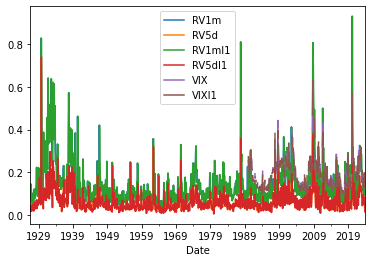

In [16]:
market_RV_vixunits=((market_RV/(100**2)*12)**0.5).merge(vix_data/100, left_index=True, right_index=True, how='left')
market_RV_vixunits.plot()

In [18]:

# Remove missing values

_temp=market_RV_vixunits.dropna()

# Add constant term
X = sm.add_constant(_temp[['RV1ml1','VIXl1']]**2)

# Fit the regression model
model = sm.OLS(_temp.RV1m**2, X)
results4 = model.fit(missing='drop')

# Print the regression results
print(results4.summary())

                            OLS Regression Results                            
Dep. Variable:                   RV1m   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     393.5
Date:                Wed, 01 May 2024   Prob (F-statistic):           1.14e-81
Time:                        18:26:48   Log-Likelihood:                 524.84
No. Observations:                 280   AIC:                            -1044.
Df Residuals:                     277   BIC:                            -1033.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0312      0.003     -9.562      0.0

Huge gain? 

Is this all about the VIX? or is there something else going on?

CLUE: What happen with the sample?


### The GARCH approach

The GARCH (Generalized Autoregressive Conditional Heteroskedasticity) model is a popular statistical model used for predicting and modeling the volatility, or variance, of financial time series data. It is widely used in finance and risk management to estimate and forecast the volatility of asset returns.

The GARCH model takes into account both the past values of the time series and the past values of the conditional variance itself.

The GARCH model is typically expressed as follows:

$$
\sigma_t^2 = \omega + \sum_{i=1}^{p} \alpha_i \epsilon_{t-i}^2 + \sum_{j=1}^{q} \beta_j \sigma_{t-j}^2
$$

where:
- $\sigma_t^2$ is the conditional variance at time $t$,
- $\omega$ is the constant term,
- $\alpha_i$ and $\beta_j$ are the coefficients of the model,
- $\epsilon_{t-i}^2$ is the squared residual at time $t-i$, and
- $\sigma_{t-j}^2$ is the conditional variance at time $t-j$.

The GARCH model allows for the estimation of the parameters $\omega$, $\alpha_i$, and $\beta_j$ using various estimation techniques such as maximum likelihood estimation. Once the parameters are estimated, the model can be used to forecast the future conditional variance of the time series.

By predicting the volatility of a financial time series, the GARCH model can be used to assess and manage risk in various financial applications, such as portfolio optimization, option pricing, and risk management strategies.

- Estimate GARCH for market

- Show T periods forecast

In [24]:
from arch import arch_model

# Assume returns is your time series data
# returns = ...
monthly_returns=market_factor.resample('M').agg(lambda x: np.prod(1+x/100)-1)
model = arch_model(monthly_returns, vol='Garch', p=1, q=1)
model_fit = model.fit()

model_fit.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 121644695.74237345
Iteration:      2,   Func. Count:     17,   Neg. LLF: 640569.4132864494
Iteration:      3,   Func. Count:     24,   Neg. LLF: 940970.6741192145
Iteration:      4,   Func. Count:     33,   Neg. LLF: -1938.7144124196502
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1938.7144099338939
            Iterations: 8
            Function evaluations: 33
            Gradient evaluations: 4


c:\Users\Alan.Moreira\Anaconda3\lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002851. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 Mkt-RF   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                1938.71
Distribution:                  Normal   AIC:                          -3869.43
Method:            Maximum Likelihood   BIC:                          -3849.17
                                        No. Observations:                 1170
Date:                Wed, May 01 2024   Df Residuals:                     1169
Time:                        18:28:26   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         7.9346e-03  1.285e-03      6.174  6.663e-10 [5.416e-03,1.045e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      5.5202e-05  1.783e-05      3.096  1.963e-03 [2.025e-05,9.015e-05]
alpha[1]       0.1286  2.074e-02      6.200  5.633e-10   [8.794e-02,  0.169]
beta[1]        0.8520  2.082e-02     40.923      0.000     [  0.811,  0.893]
============================================================================

Covariance estimator: robust
"""

c:\Users\Alan.Moreira\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


<AxesSubplot:xlabel='Date'>

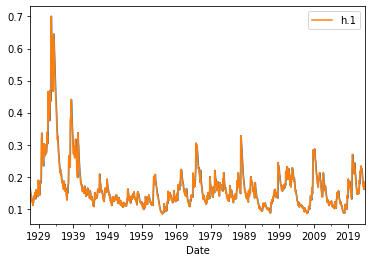

In [25]:
# this is the model best estimate of volatility at a given point in time
ax=(model_fit.conditional_volatility*12**0.5).plot()
# If we want next period volatility

forecasts = model_fit.forecast(start=0,horizon=1)

# Get the variance
variance_forecast = forecasts.variance*12

# Get the standard deviation (volatility) by taking the square root of the variance
((variance_forecast)**0.5).plot(ax=ax)



Basically on top of each other

Lets look at how it forecasts for a given date how volatiltiy will behave many month in the future

c:\Users\Alan.Moreira\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


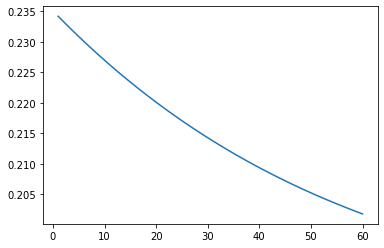

In [26]:
h=60
forecasts = model_fit.forecast(start=0,horizon=h)

# Get the variance
variance_forecast = forecasts.variance

# Get the standard deviation (volatility) by taking the square root of the variance
volatility_forecast = (variance_forecast*12)**0.5

# Print the 3-month ahead forecasted volatility for all data points
plt.plot(range(1,h+1),volatility_forecast.loc['2020-03'].values.T)



Which one is better?

different approaches to deal with this

There is a whole field dedicated to forecasting

But the basic idea is simple

You wan to have some penalty for it: What is the cost of getting it wrong?

We could simply have a penalty:

$$\gamma E[(Variance(model)-Variance(Truth))^2]$$

Basically this the "Mean-Squared Error" approach to evaluating forecasts

Here we need some estimate of the true variance

Below we assume it is the realized variance

It is very important that they are in the same units!

In [34]:
# This is the model that that uses VIX

print(((results4.fittedvalues- market_RV_vixunits.RV1m**2)**2).mean()/(market_RV_vixunits.RV1m**2).var()) # divide by the variable variance to have a sense of how big are your mistakes!

# this is the model that use 5 days and 1 month lagged RV (but much longer sample!)
print(((results3.fittedvalues- market_RV.RV1m)**2).mean()/(market_RV.RV1m).var()) #multiply to put in the same units



0.34890446461669083
0.6810322887390576


How do you make it more comparable?

Lets add the GARCH to the mix

In [28]:
forecasts = model_fit.forecast(start=0,horizon=1)
# Get the variance
variance_forecast = forecasts.variance*12

# check units!

print(variance_forecast.mean())
print((market_RV.RV1m**2).mean())




h.1    0.034199
dtype: float64
3399.012434626065


c:\Users\Alan.Moreira\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


In [31]:
print(((variance_forecast['h.1']- market_RV.RV1m**2)**2).mean()/(market_RV.RV1m**2).var()) #multiply to put in the same units

1.0191992250394422


Note that to make it comparable we should look at similar samples.

Why is that? How would you do that?

## Dynamic Portfolios

The key idea here will be to use the factor structure idea for returns together with a GARCH or RV model for the market return volatility.

The idea here is

- Correlations do change, but they change slower than variance so we will use standard rolling window to estimate correlations--essentially assuming that they are constant in our forecast horizon.

- And use our model to forecast the the variance

IF returns have a factor structure we have

$$Var_t(R_{t+1})=Var(\beta_t F_{t+1}+u_{t+1})=\beta_t Var_t(F) \beta_t'+Var_t(u)$$


We thus need to produce time-varying estimates 

- for the time-varying betas
- For the entire factor covariance matrix
- For each asset specific volatility


Suppose we have single factor model--

then we have 


$$Var_t(R^i_{t+1})=\beta_{i,t}^2 \sigma^2_{f,t} +\sigma^2_{i,t}(u)$$

and 

$$Cov_t(R^i_{t+1},R^j_{t+1})=\beta_{i,t}*\beta_{j,t}\sigma^2_{f,t} $$

or in matrix form

$$Var_t(R_{t+1})=\beta_{t} \beta_{t}'\sigma^2_{f,t} +\Sigma_{u,t}$$

where $\Sigma_{u,t}$ is a diagonal matrix 

You see there are many things to estimate!

Do I really need to estimate all these things?

- Depend of what are your assets
- Depend on how well you can estimate them

There is a whole industry of estimating factor Betas for different assets
4
You can get quite sophisticated.

To get started:

- Rolling 5 year window estimate for the betas
- Assume variances move together with the market variance


$$\Sigma_{u,t}=\Sigma_{u}*\frac{\sigma^2_{market,t}}{\sigma^2_{market}}$$



$$\Sigma_{F,t}=\Sigma_{F}*\frac{\sigma^2_{market,t}}{\sigma^2_{market}}$$

- Invest in trying to forecast market variance well 
- use factor model to extrapolate implications to variance-covariance matrix

Note: These are all assumptions. You have to check if they are good approximation and ultimate if indeed they help you forecast the variance of your portfolio!




## Risk-Budget Constraint

- How this is used in practice?
- In practice a fund or a "trading pod" is allocated some capital and some maximum risk-limits
- If you breach the risk-limit you have to de-risk
- Why is typically so hard to de-risk?
- Think about Melvin Capital. 
  - How should you think about de-risking? Should you comply? What is the trade-off?
  - What are the incentives the manager faces? What does it depend on?
  - How are these incentives different from a wealth individual invest in her own behalf?
- Should our past losses matter for our decision to de-risk?

## Tracking Error Constraint

- One can use exactly the same model to compute the tracking error
- it is simply the volatility of a relative return
- How would you adjust our math above to estimate the tracking error instead of the absolute risk?

Suppose we have many assets, all respecting this factor model. Say $R_t^e$ is the big N by 1 vector of excess return $[r_{t}^{e,1},r_{t}^{e,2},...]$ for all these assets

$$R_t^e=Bf_t+U_t$$

where $B$ is also a N by 1 vector of exposures $[\beta_1,\beta_2,...\beta_N]$  and $u_t$ is the N by 1 vector of shocks $[\epsilon_1,\epsilon_2,...]$


Then their variance-covariance matrix is simply


$$Var(R^e_t)=B @ B' Var(f_t)+ Var(U_t)$$

- Armed with the variance covariance of assets we have the variance of any portfolio of these assets 

- To construct $Var(U_t)$ you can stack all the residuals of the individual regression in a dataframe and compute the variance
- This will give you a vector S with N numbers, the you can use ``np.diag(S)`` to created a diagonal matrix with these variances in the diagonal

 

